In [1]:
"""
    Total Trámites, Total Radicados, Total Finalizados
"""

'\n    Total Trámites, Total Radicados, Total Finalizados\n'

<h3>Importación Librerías</h3>

In [2]:
import pandas as pd
import os
import seaborn as sns

os.environ["CRYPTOGRAPHY_OPENSSL_NO_LEGACY"] = "yes"

# ? Se usa para generar gráficos
import matplotlib.pyplot as plt

# ? Se usa para determina la fecha de ejecución del proceso dentro del export de los resultados estadísticos
from datetime import datetime

# ? Conexión a BD Postgres. Se usa dado que pandas no acepta sino este paquete para la conexión.
from sqlalchemy import create_engine, text

from datetime import datetime as dt

from arcgis.features import GeoAccessor, GeoSeriesAccessor
import arcpy

from pathlib import Path

# ** Librerías propias
import funcion_parametrizacion_variables
import funcion_SQL_a_DataFrame

<h3>Ejecución de Función de Variables</h3>

In [3]:
resultado = funcion_parametrizacion_variables.parametrizacion_variables()
consulta_tRadicados = resultado[0]
consuta_tFinalizados = resultado[1]
nombre_procesos = resultado[8]

<h3>Parametrización de Variables</h3>

In [4]:
consulta_tRadicados = consulta_tRadicados
consuta_tFinalizados = consuta_tFinalizados

columnas_estado = ['ATENDIENDO','PENDIENTE','DEVUELTO']

nombre_procesos = nombre_procesos

modificacion_estado_proceso = {1:['Proceso cancelado por falta de documentos','Cancelado por falta de documentos']}

XLSX_UNIFICADO = r"C:\docsProyectos\5.RAISS\2024.0.RAISS_Lote_4\6.Hitos\E2_Informes_Id_FisicoJuridica\2_2_1_Identificacion_Predial_Total_Tramites\2_2_1_Identificacion_Predial_Total_Tramites.xlsx"

RUTA_RAIZ = r"C:\docsProyectos\5.RAISS\2024.0.RAISS_Lote_4\6.Hitos\E2_Informes_Id_FisicoJuridica\2_2_1_Identificacion_Predial_Total_Tramites"
NOMBRE_IND_2_2_1 = 'Seguimiento_Diario'

fecha_actual = dt.now()
fecha_directorio = str(fecha_actual.strftime("%Y-%m-%d"))

<h3>Ejecución de Funciones</h3>

In [5]:
df_consulta_radicados = funcion_SQL_a_DataFrame.sql_a_dataframe(consulta_tRadicados)
df_consulta_finalizados = funcion_SQL_a_DataFrame.sql_a_dataframe(consuta_tFinalizados)

Inicio de la conexión
Conexión exitosa ...
Inicio de la conexión
Conexión exitosa ...


<h3>Preparación Registros para Indicador General</h3>

<ol>
    <li>Total Trámites (Radicado\Finalizado)
    <li>Total Trámites (Radicado\Finalizado) Por Municipio
    <li>Total Trámites (Radicado\Finalizado) Por Municipio y Proceso
</ol>

In [6]:

# TODO: Total Trámites (Radicado\Finalizado)
total_radicados = df_consulta_radicados.shape[0] + df_consulta_finalizados.shape[0]
# ** De esta forma se almacena un numéro entero como un DF
df_total_radicados = pd.DataFrame([[total_radicados]], columns=['Total Radicados'])
print(f"1. El total de trámites generados a la fecha es de: {total_radicados} \n")

# TODO: Total Trámites (Radicado\Finalizado) Por Municipio
df_tramites_x_municipio = pd.DataFrame(pd.DataFrame(pd.concat([df_consulta_radicados['municipio'], df_consulta_finalizados['municipio']], ignore_index=True)).value_counts('municipio')).reset_index().rename(columns={'count':'total_tramites'})
print(f"2. Por municipio, el total de trámites es el siguiente: \n {df_tramites_x_municipio} \n")

# TODO: Total Trámites (Radicado\Finalizado) Por Municipio y Proceso
df_consulta_radicados['tramite'] = 'Radicado'
df_consulta_finalizados['tramite'] = 'Finalizado'

# ! Para la gráfica
df_tramite_x_mun_x_proceso = pd.DataFrame(pd.concat([df_consulta_radicados[['municipio','tramite']], df_consulta_finalizados[['municipio','tramite']]], ignore_index=True).value_counts()).reset_index().rename(columns={'count':'total_tramites'})

df_tramite_x_mun_x_proceso_pivote = df_tramite_x_mun_x_proceso.pivot(index='municipio', columns = 'tramite', values = 'total_tramites')

columnas_proceso = ['Finalizado','Radicado']

for columna in columnas_proceso:
    if columna in df_tramite_x_mun_x_proceso_pivote.columns:
        df_tramite_x_mun_x_proceso_pivote.loc[df_tramite_x_mun_x_proceso_pivote[columna].isnull(), columna] = 0
        df_tramite_x_mun_x_proceso_pivote[columna] = df_tramite_x_mun_x_proceso_pivote[columna].astype(int)

df_tramite_x_mun_x_proceso_pivote['%_Avance'] = ((df_tramite_x_mun_x_proceso_pivote['Finalizado']/df_tramite_x_mun_x_proceso_pivote['Radicado'])*100).round(2)

# ! Para generación de Tabla
print(f"3. Trámites Radicados y Cerrados por Municipio: \n {df_tramite_x_mun_x_proceso_pivote} \n")

1. El total de trámites generados a la fecha es de: 7306 

2. Por municipio, el total de trámites es el siguiente: 
        municipio  total_tramites
0  MARÍA LA BAJA            4792
1        REPELÓN            2488
2        BARANOA              24
3   SABANAGRANDE               2 

3. Trámites Radicados y Cerrados por Municipio: 
 tramite        Finalizado  Radicado  %_Avance
municipio                                    
BARANOA                 1        23      4.35
MARÍA LA BAJA           1      4791      0.02
REPELÓN                 0      2488      0.00
SABANAGRANDE            0         2      0.00 



<h3>Preparación Registros para Indicador Detallado de Radicados</h3>

In [7]:

# TODO: Total Radicados por Municipio y Proceso
# ! Para gráfica
df_consulta_radicados_proceso = df_consulta_radicados[['municipio','Proceso']].value_counts().reset_index().rename(columns={'count':'total_radicados'})

# ! Para Tabla
df_consulta_radicados_proceso_pivote = df_consulta_radicados_proceso.pivot(index="municipio", columns="Proceso", values="total_radicados")
print(f"1.1 Dentro de los trámites radicados, por estado la relación es: \n {df_consulta_radicados_proceso_pivote} \n")

# TODO: Total Finalizados por Municipio y Proceso
# ! Para gráfica
df_consulta_finalizados_proceso = df_consulta_finalizados[['municipio','Proceso']].value_counts().reset_index().rename(columns={'count':'total_radicados'})

# ! Para Tabla
df_consulta_finalizados_proceso_pivote = df_consulta_finalizados_proceso.pivot(index="municipio", columns="Proceso", values="total_radicados")
print(f"1.2 Dentro de los trámites finalizados, por estado la relación es: \n {df_consulta_finalizados_proceso_pivote}")

1.1 Dentro de los trámites radicados, por estado la relación es: 
 Proceso        Actualización  Conservación
municipio                                 
BARANOA                  NaN          23.0
MARÍA LA BAJA         4786.0           5.0
REPELÓN               2478.0          10.0
SABANAGRANDE             NaN           2.0 

1.2 Dentro de los trámites finalizados, por estado la relación es: 
 Proceso        Conservación
municipio                  
BARANOA                   1
MARÍA LA BAJA             1


<h3>Analítica sobre proceso de Conservación - Radicados</h3>
<ol>
    <li> Total de Trámites de Conservación por Estado
    <li> Nombre de procesos detallado por estado de atención del trámite
</ol>

In [8]:

query_conservacion = "Proceso == 'Conservación'"

# TODO: Total de Trámites de Conservación por Estado

# ! Para Gráfica
df_consulta_radicados_conservacion = df_consulta_radicados.query(query_conservacion)
df_consulta_radicados_conservacion_estado = pd.DataFrame(df_consulta_radicados_conservacion[['municipio','vr_estado_paso']].value_counts()).reset_index().rename(columns={'count':'total_estado'})

# ! Para Tabla
df_consulta_radicados_conservacion_estado_pivote = df_consulta_radicados_conservacion_estado.pivot(index="municipio", columns="vr_estado_paso", values="total_estado")

for columna in columnas_estado:
    if columna in df_consulta_radicados_conservacion_estado_pivote.columns:
        df_consulta_radicados_conservacion_estado_pivote.loc[df_consulta_radicados_conservacion_estado_pivote[columna].isnull(), columna] = 0
        df_consulta_radicados_conservacion_estado_pivote[columna] = df_consulta_radicados_conservacion_estado_pivote[columna].astype(int)

print(f"1. Para el proceso de Conservación, se presentan la siguiente cantidad de trámites segun su estado: \n {df_consulta_radicados_conservacion_estado_pivote} \n")

# TODO: 2. Nombre de procesos detallado por estado de atención del trámite
dataframes = {}

for estado in columnas_estado:
    query_conservacion_estado = "Proceso == 'Conservación' and vr_estado_paso == "+"'"+estado+"'"
    df = df_consulta_radicados.query(query_conservacion_estado)
    dataframes[estado] = df

# ** Se Asigna los dataframes del diccionario a variables individuales automáticamente
for estado, df in dataframes.items():
    globals()[f'df_{estado}'] = df
    globals()[f'df_{estado}_Filtrado_Conservacion'] = pd.DataFrame(globals()[f'df_{estado}'][['municipio','vr_nombre_proceso']]).value_counts().reset_index().rename(columns={'count':'total'})
    globals()[f'df_{estado}_Filtrado_Conservacion_Pivoteo'] = globals()[f'df_{estado}_Filtrado_Conservacion'].pivot(index="municipio", columns="vr_nombre_proceso", values="total")
    for columna in nombre_procesos:
        if columna in globals()[f'df_{estado}_Filtrado_Conservacion_Pivoteo'].columns:
            globals()[f'df_{estado}_Filtrado_Conservacion_Pivoteo'].loc[globals()[f'df_{estado}_Filtrado_Conservacion_Pivoteo'][columna].isnull(), columna] = 0
            globals()[f'df_{estado}_Filtrado_Conservacion_Pivoteo'][columna] = globals()[f'df_{estado}_Filtrado_Conservacion_Pivoteo'][columna].astype(int)

# ! Para Gráficas
df_ATENDIENDO_Filtrado_Conservacion
df_PENDIENTE_Filtrado_Conservacion
df_DEVUELTO_Filtrado_Conservacion

# ! Para Tablas
df_ATENDIENDO_Filtrado_Conservacion_Pivoteo
df_PENDIENTE_Filtrado_Conservacion_Pivoteo
df_DEVUELTO_Filtrado_Conservacion_Pivoteo

1. Para el proceso de Conservación, se presentan la siguiente cantidad de trámites segun su estado: 
 vr_estado_paso  ATENDIENDO
municipio                 
BARANOA                 23
MARÍA LA BAJA            5
REPELÓN                 10
SABANAGRANDE             2 



vr_nombre_proceso
municipio


<h3>Analítica sobre proceso de Conservación - Finalizados</h3>
<ol>
    <li> Total Finalizado por Nombre de Proceso
    <li> Finalizado Nombre Proceso Vs Motivo (Estado Tarea)
</ol>

In [9]:

query_conservacion = "Proceso == 'Conservación'"

# TODO: 1. Total de Trámites Finalizados de Conservación por Nombre Proceso

# ! Para Gráfica
df_consulta_finalizados_conservacion = df_consulta_finalizados.query(query_conservacion)

df_consulta_finalizados_conservacion_proceso = df_consulta_finalizados_conservacion[['municipio','vr_nombre_proceso']].value_counts().reset_index().rename(columns={'count':'total'})

# ! Para Tabla
df_consulta_finalizados_conservacion_proceso_pivote = df_consulta_finalizados_conservacion_proceso.pivot(index="municipio", columns="vr_nombre_proceso", values="total")

for columna in nombre_procesos:
    if columna in df_consulta_finalizados_conservacion_proceso_pivote.columns:
        df_consulta_finalizados_conservacion_proceso_pivote.loc[df_consulta_finalizados_conservacion_proceso_pivote[columna].isnull(), columna] = 0
        df_consulta_finalizados_conservacion_proceso_pivote[columna] = df_consulta_finalizados_conservacion_proceso_pivote[columna].astype(int)

print(f"1. Total de Trámites Finalizados de Conservación por Nombre Proceso \n {df_consulta_finalizados_conservacion_proceso_pivote} \n")

# TODO: 2. Finalizado Nombre Proceso Vs Motivo (Estado Tarea)
df_consulta_finalizados_conservacion_motivo = df_consulta_finalizados_conservacion[['municipio','vr_nombre_proceso','vr_task_est']].value_counts().reset_index().rename(columns={'count':'total'})

for llave, valor in modificacion_estado_proceso.items():
    df_consulta_finalizados_conservacion_motivo.loc[df_consulta_finalizados_conservacion_motivo['vr_task_est'] == valor[0], 'vr_task_est'] = valor[1]

# ** Unifico dos columnas buscando generar una gráfica más indicadora
df_consulta_finalizados_conservacion_motivo['municipio_nProceso'] = df_consulta_finalizados_conservacion_motivo['municipio'] + ' - ' + df_consulta_finalizados_conservacion_motivo['vr_nombre_proceso']

1. Total de Trámites Finalizados de Conservación por Nombre Proceso 
 vr_nombre_proceso  Complementación - Rectificación de Propietario  \
municipio                                                           
BARANOA                                                       NaN   
MARÍA LA BAJA                                                 1.0   

vr_nombre_proceso  Mutaciones de Segunda Clase  
municipio                                       
BARANOA                                      1  
MARÍA LA BAJA                                0   



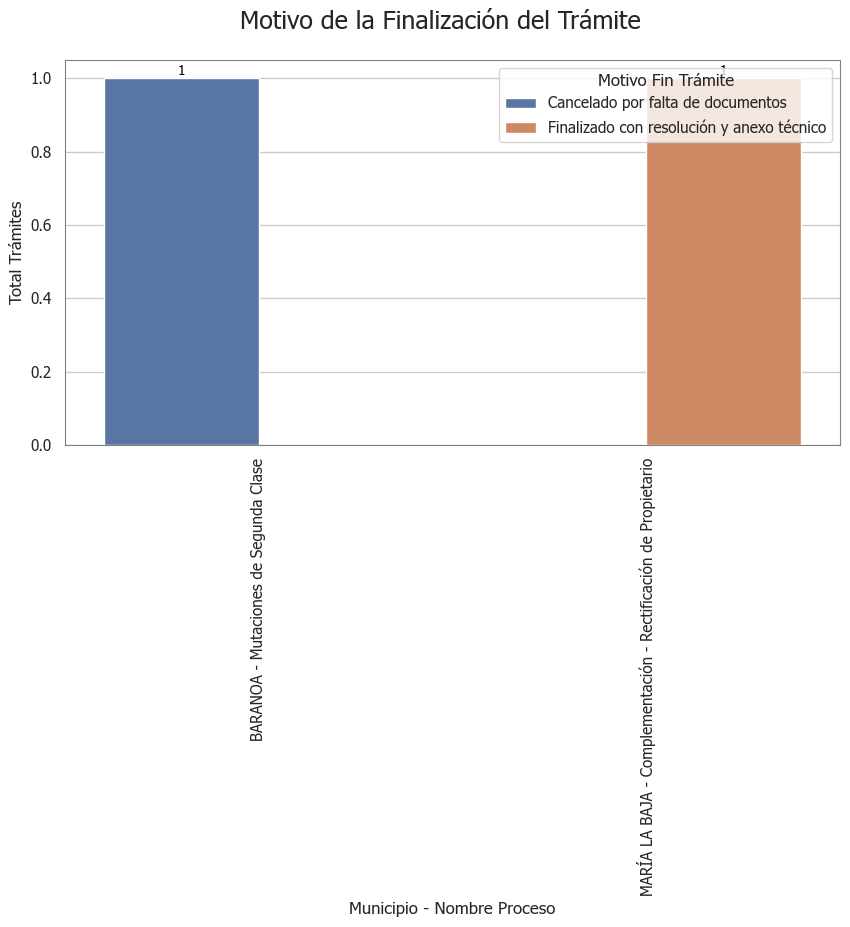

In [10]:
modificacion_estado_proceso = {1:['Proceso cancelado por falta de documentos','Cancelado por falta de documentos']}

# ** Aplicar tema a la salida gráfica y tipo de texto y tamaño del texto
sns.set_theme(style='whitegrid', font='Tahoma', font_scale=1)

# ** Configuración ejes horizontales en Matplotlib
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.edgecolor'] = 'gray'
plt.rcParams['axes.linewidth'] = 0.8

fig = plt.figure(figsize = (10, 5))

ax = sns.barplot(data=df_consulta_finalizados_conservacion_motivo, x='municipio_nProceso', y='total', hue='vr_task_est', errorbar=None)

# ** Se rota las etiquetas del eje x
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# ** Se parametriza la leyenda 
ax.legend(title='Motivo Fin Trámite', loc='best')

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10, color='black')

# ** Titulos
fig.suptitle('Motivo de la Finalización del Trámite', fontsize=18)
ax.set_ylabel("Total Trámites")
ax.set_xlabel("Municipio - Nombre Proceso")

plt.show()

<h3>Analítica sobre proceso de Actualización - Radicados</h3>
<ol>
    <li> Total de Trámites de Actualización por Estado
    <li> Nombre de procesos detallado por estado de atención del trámite
</ol>

In [11]:
query_actualizacion = "Proceso == 'Actualización'"

# TODO: Total de Trámites de Actualización por Estado

# ! Para Gráfica
df_consulta_radicados_actualizacion = df_consulta_radicados.query(query_actualizacion)
df_consulta_radicados_actualizacion_estado = pd.DataFrame(df_consulta_radicados_actualizacion[['municipio','vr_estado_paso']].value_counts()).reset_index().rename(columns={'count':'total_estado'})

# ! Para Tabla
df_consulta_radicados_actualizacion_estado_pivote = df_consulta_radicados_actualizacion_estado.pivot(index="municipio", columns="vr_estado_paso", values="total_estado")

for columna in columnas_estado:
    if columna in df_consulta_radicados_actualizacion_estado_pivote.columns:
        df_consulta_radicados_actualizacion_estado_pivote.loc[df_consulta_radicados_actualizacion_estado_pivote[columna].isnull(), columna] = 0
        df_consulta_radicados_actualizacion_estado_pivote[columna] = df_consulta_radicados_actualizacion_estado_pivote[columna].astype(int)

print(f"1. Para el proceso de Actualización, se presentan la siguiente cantidad de trámites segun su estado: \n {df_consulta_radicados_actualizacion_estado_pivote} \n")

# TODO: 2. Nombre de procesos detallado por estado de atención del trámite
dataframes = {}

for estado in columnas_estado:
    query_actualizacion_estado = "Proceso == 'Actualización' and vr_estado_paso == "+"'"+estado+"'"
    df = df_consulta_radicados.query(query_actualizacion_estado)
    dataframes[estado] = df

# ** Se Asigna los dataframes del diccionario a variables individuales automáticamente
for estado, df in dataframes.items():
    globals()[f'df_{estado}'] = df
    globals()[f'df_{estado}_Filtrado_Actualizacion'] = pd.DataFrame(globals()[f'df_{estado}'][['municipio','vr_nombre_proceso']]).value_counts().reset_index().rename(columns={'count':'total'})
    globals()[f'df_{estado}_Filtrado_Actualizacion_Pivoteo'] = globals()[f'df_{estado}_Filtrado_Actualizacion'].pivot(index="municipio", columns="vr_nombre_proceso", values="total")
    for columna in nombre_procesos:
        if columna in globals()[f'df_{estado}_Filtrado_Actualizacion_Pivoteo'].columns:
            globals()[f'df_{estado}_Filtrado_Actualizacion_Pivoteo'].loc[globals()[f'df_{estado}_Filtrado_Actualizacion_Pivoteo'][columna].isnull(), columna] = 0
            globals()[f'df_{estado}_Filtrado_Actualizacion_Pivoteo'][columna] = globals()[f'df_{estado}_Filtrado_Actualizacion_Pivoteo'][columna].astype(int)

# ! Para Gráficas
df_ATENDIENDO_Filtrado_Actualizacion
df_PENDIENTE_Filtrado_Actualizacion
df_DEVUELTO_Filtrado_Actualizacion

# ! Para Tablas
df_ATENDIENDO_Filtrado_Actualizacion_Pivoteo
df_PENDIENTE_Filtrado_Actualizacion_Pivoteo
df_DEVUELTO_Filtrado_Actualizacion_Pivoteo

1. Para el proceso de Actualización, se presentan la siguiente cantidad de trámites segun su estado: 
 vr_estado_paso  ATENDIENDO
municipio                 
MARÍA LA BAJA         4786
REPELÓN               2478 



vr_nombre_proceso
municipio


<h3>Analítica sobre proceso de Actualización - Finalizados</h3>
<ol>
    <li> Total Finalizado por Nombre de Proceso
    <li> Finalizado Nombre Proceso Vs Motivo (Estado Tarea)
</ol>

In [12]:
query_actualizacion = "Proceso == 'Actualización'"

# TODO: 1. Total de Trámites de Actualización por Nombre Proceso

# ! Para Gráfica
df_consulta_finalizados_actualizacion = df_consulta_finalizados.query(query_actualizacion)

df_consulta_finalizados_actualizacion_proceso = df_consulta_finalizados_actualizacion[['municipio','vr_nombre_proceso']].value_counts().reset_index().rename(columns={'count':'total'})

# ! Para Tabla
df_consulta_finalizados_actualizacion_proceso_pivote = df_consulta_finalizados_actualizacion_proceso.pivot(index="municipio", columns="vr_nombre_proceso", values="total")

for columna in nombre_procesos:
    if columna in df_consulta_finalizados_actualizacion_proceso_pivote.columns:
        df_consulta_finalizados_actualizacion_proceso_pivote.loc[df_consulta_finalizados_actualizacion_proceso_pivote[columna].isnull(), columna] = 0
        df_consulta_finalizados_actualizacion_proceso_pivote[columna] = df_consulta_finalizados_actualizacion_proceso_pivote[columna].astype(int)

print(f"1. Total de Trámites de Actualización Finalizados por Nombre Proceso \n {df_consulta_finalizados_actualizacion_proceso_pivote} \n")

# TODO: 2. Finalizado Nombre Proceso Vs Motivo (Estado Tarea)
df_consulta_finalizados_actualizacion_motivo = df_consulta_finalizados_actualizacion[['municipio','vr_nombre_proceso','vr_task_est']].value_counts().reset_index().rename(columns={'count':'total'})

for llave, valor in modificacion_estado_proceso.items():
    df_consulta_finalizados_actualizacion_motivo.loc[df_consulta_finalizados_actualizacion_motivo['vr_task_est'] == valor[0], 'vr_task_est'] = valor[1]

# ** Unifico dos columnas buscando generar una gráfica más indicadora
df_consulta_finalizados_actualizacion_motivo['municipio_nProceso'] = df_consulta_finalizados_actualizacion_motivo['municipio'] + ' - ' + df_consulta_finalizados_actualizacion_motivo['vr_nombre_proceso']

1. Total de Trámites de Actualización Finalizados por Nombre Proceso 
 Empty DataFrame
Columns: []
Index: [] 



<h3>Generación de XLSX Unificado</h3>

In [13]:

# ** Usar ExcelWriter para guardar múltiples dataframes en diferentes hojas
with pd.ExcelWriter(XLSX_UNIFICADO, engine='xlsxwriter') as writer:
    df_total_radicados.to_excel(writer, sheet_name='1_TotalRadicados', index=False)
    df_tramites_x_municipio.to_excel(writer, sheet_name='2_TramitesXMunicipio', index=False)
    df_tramite_x_mun_x_proceso_pivote.to_excel(writer, sheet_name='3_TramiteXMunXVigencia', index=True)
    df_consulta_radicados_proceso_pivote.to_excel(writer, sheet_name='6_TRadicadoXMunXProceso', index=True)
    df_consulta_finalizados_proceso_pivote.to_excel(writer, sheet_name='7_TFinalizadoXMunXProceso', index=True)
    df_consulta_radicados_conservacion_estado_pivote.to_excel(writer, sheet_name='8_TConsXMunXEstado', index=True)
    df_ATENDIENDO_Filtrado_Conservacion_Pivoteo.to_excel(writer, sheet_name='9_1_TConsXMunXEAtendiendo', index=True)
    df_PENDIENTE_Filtrado_Conservacion_Pivoteo.to_excel(writer, sheet_name='9_2_TConsXMunXEPendiente', index=True)
    df_DEVUELTO_Filtrado_Conservacion_Pivoteo.to_excel(writer, sheet_name='9_3_TConsXMunXEDevuelto', index=True)
    df_consulta_finalizados_conservacion_proceso_pivote.to_excel(writer, sheet_name='10_TConserXMunXProDetallado', index=True)
    df_consulta_radicados_actualizacion_estado_pivote.to_excel(writer, sheet_name='12_TActualizacionXMunXEstado', index=True)
    df_ATENDIENDO_Filtrado_Actualizacion_Pivoteo.to_excel(writer, sheet_name='13_1_TConXMunXEAtendiendo', index=True)
    df_PENDIENTE_Filtrado_Actualizacion_Pivoteo.to_excel(writer, sheet_name='13_2_TConXMunXEPendiente', index=True)
    df_DEVUELTO_Filtrado_Actualizacion_Pivoteo.to_excel(writer, sheet_name='13_3_TConsXMunXEDevuelto', index=True)
    df_consulta_finalizados_actualizacion_proceso_pivote.to_excel(writer, sheet_name='14_TActuXMunXProcDetallado', index=True)

print(f'Dataframes guardados en {XLSX_UNIFICADO}')

Dataframes guardados en C:\docsProyectos\5.RAISS\2024.0.RAISS_Lote_4\6.Hitos\E2_Informes_Id_FisicoJuridica\2_2_1_Identificacion_Predial_Total_Tramites\2_2_1_Identificacion_Predial_Total_Tramites.xlsx


In [14]:

dir_directorio_salidas_xlsx = {1:[df_total_radicados,'1_TotalRadicados.xlsx','1_TotalRadicados'],
    2:[df_tramites_x_municipio,'2_TramitesXMunicipio.xlsx','2_TramitesXMunicipio'],
    3:[df_tramite_x_mun_x_proceso_pivote,'3_TramiteXMunXVigencia.xlsx','3_TramiteXMunXVigencia'],
    4:[df_consulta_radicados_proceso_pivote,'6_TRadicadoXMunXProceso.xlsx','6_TRadicadoXMunXProceso'],
    5:[df_consulta_finalizados_proceso_pivote,'7_TFinalizadoXMunXProceso.xlsx','7_TFinalizadoXMunXProceso'],
    6:[df_consulta_radicados_conservacion_estado_pivote,'8_TConservacionXMunXEstado.xlsx','8_TConservacionXMunXEstado'],
    7:[df_ATENDIENDO_Filtrado_Conservacion_Pivoteo,'9_1_TConsXMunXEAtendiendo.xlsx','9_1_TConsXMunXEAtendiendo'],
    8:[df_PENDIENTE_Filtrado_Conservacion_Pivoteo,'9_2_TConsXMunXEPendiente.xlsx','9_2_TConsXMunXEPendiente'],
    9:[df_DEVUELTO_Filtrado_Conservacion_Pivoteo,'9_3_TConsXMunXEDevuelto.xlsx','9_3_TConsXMunXEDevuelto'],
    10:[df_consulta_finalizados_conservacion_proceso_pivote,'10_TConserXMunXProDetallado.xlsx','10_TConserXMunXProDetallado'],
    11:[df_consulta_radicados_actualizacion_estado_pivote,'12_TActualizacionXMunXEstado.xlsx','12_TActualizacionXMunXEstado'],
    12:[df_ATENDIENDO_Filtrado_Actualizacion_Pivoteo,'13_1_TConXMunXEAtendiendo.xlsx','13_1_TConXMunXEAtendiendo'],
    13:[df_PENDIENTE_Filtrado_Actualizacion_Pivoteo,'13_2_TConXMunXEPendiente.xlsx','13_2_TConXMunXEPendiente'],
    14:[df_DEVUELTO_Filtrado_Actualizacion_Pivoteo,'13_3_TConsXMunXEDevuelto.xlsx','13_3_TConsXMunXEDevuelto'],
    15:[df_consulta_finalizados_actualizacion_proceso_pivote,'14_TActuXMunXProcDetallado.xlsx','14_TActuXMunXProcDetallado']
    }

if os.path.exists(os.path.join(RUTA_RAIZ, NOMBRE_IND_2_2_1, fecha_directorio)):
    for llave, valor in dir_directorio_salidas_xlsx.items():
        valor[0].to_excel(os.path.join(RUTA_RAIZ, NOMBRE_IND_2_2_1, fecha_directorio,valor[1]), sheet_name=valor[2])
        print(f"Se genera XLSX de DF {valor[1]}")
else:
    os.mkdir(os.path.join(RUTA_RAIZ, NOMBRE_IND_2_2_1, fecha_directorio))
    for llave, valor in dir_directorio_salidas_xlsx.items():
        valor[0].to_excel(os.path.join(RUTA_RAIZ, NOMBRE_IND_2_2_1, fecha_directorio,valor[1]), sheet_name=valor[2])
        print(f"Se genera XLSX de DF {valor[1]}")

Se genera XLSX de DF 1_TotalRadicados.xlsx
Se genera XLSX de DF 2_TramitesXMunicipio.xlsx
Se genera XLSX de DF 3_TramiteXMunXVigencia.xlsx
Se genera XLSX de DF 6_TRadicadoXMunXProceso.xlsx
Se genera XLSX de DF 7_TFinalizadoXMunXProceso.xlsx
Se genera XLSX de DF 8_TConservacionXMunXEstado.xlsx
Se genera XLSX de DF 9_1_TConsXMunXEAtendiendo.xlsx
Se genera XLSX de DF 9_2_TConsXMunXEPendiente.xlsx
Se genera XLSX de DF 9_3_TConsXMunXEDevuelto.xlsx
Se genera XLSX de DF 10_TConserXMunXProDetallado.xlsx
Se genera XLSX de DF 12_TActualizacionXMunXEstado.xlsx
Se genera XLSX de DF 13_1_TConXMunXEAtendiendo.xlsx
Se genera XLSX de DF 13_2_TConXMunXEPendiente.xlsx
Se genera XLSX de DF 13_3_TConsXMunXEDevuelto.xlsx
Se genera XLSX de DF 14_TActuXMunXProcDetallado.xlsx
